In [85]:
0 < -89

False

In [90]:
import networkx as nx
from pprint import pprint

g = nx.read_graphml("../simulator/test_data/firenze_45_28.graphml")
#pprint(list(g.edges(data=True)))
for src,tgt, d in g.copy().edges(data=True):
    if d['pathloss'] < -80 or \
       (g.nodes[src]['iab_type'] == 'gnb' and g.nodes[tgt]['iab_type'] == 'gnb') or \
       (g.nodes[src]['iab_type'] == 'mt' and g.nodes[tgt]['iab_type'] == 'mt'):
        g.remove_edge(src,tgt)
        #print(f"remove {src} {tgt} {d['pathloss'] < -80}")
    else:
        #print(f"not remove {src} {tgt}")
        g[src][tgt]['weight'] = -g[src][tgt]['pathloss']


In [107]:
donors = [n for n in g.nodes() if g.nodes[n]['type'] == 'donor' and g.nodes[n]['iab_type'] == 'gnb']
#donors = ['8_relay']

Compute the Shortest Path Forest

In [103]:
def getweight(src, tgt, d):
    return -d['pathloss']

end_nodes = [n for n in g.nodes() if g.nodes[n]['type'] == 'relay' and g.nodes[n]['iab_type'] == 'gnb' and n not in donors]
paths = nx.multi_source_dijkstra_path(g, donors, weight=getweight)
topo = nx.Graph()
topo.add_nodes_from(g.nodes(data=True))
for src, p in paths.items():
    if src in end_nodes:
        for pdx in range(len(p)-1):
            #print(f"{p[pdx]} {p[pdx+1]}")
            topo.add_edge(p[pdx], p[pdx+1])
topo.remove_nodes_from(list(nx.isolates(topo)))


Visualize the SPF

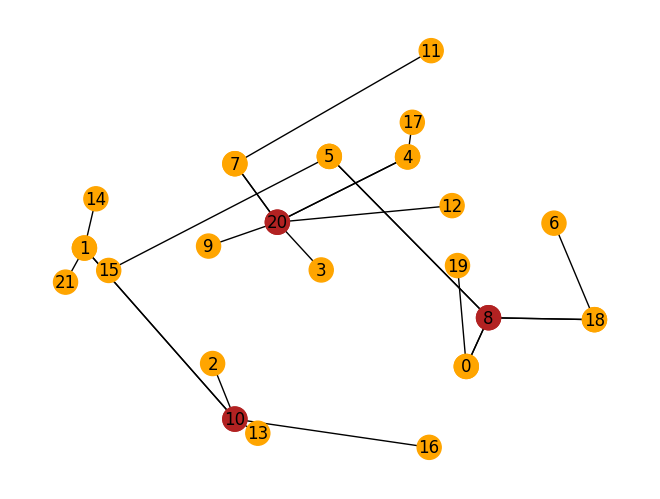

In [104]:
def get_node_color(type):
    if type == 'relay':
        return 'orange'
    elif type == 'donor':
        return 'firebrick'
    return 'yellow'
pos = {n: (d['y'], d['x']) for n, d in topo.nodes(data=True)}
nx.draw(topo, 
        pos=pos, 
        node_color=[get_node_color(d['type']) for n, d in topo.nodes(data=True)])
a = nx.draw_networkx_labels(topo, pos=pos, labels={n:n.split('_')[0] for n in topo.nodes() if topo.nodes[n]['iab_type'] == 'gnb'})



Map the IAB channel assignment problem to a node colouring

{'8_relay': 0, '20_relay': 0, '10_relay': 0, '8_mt': 1, '0_mt': 1, '18_mt': 1, '5_mt': 1, '10_mt': 1, '1_mt': 1, '20_mt': 1, '7_mt': 1, '4_mt': 1}
['red', 'green', 'green', 'green', 'green', 'red', 'green', 'green', 'red', 'green', 'green', 'green']


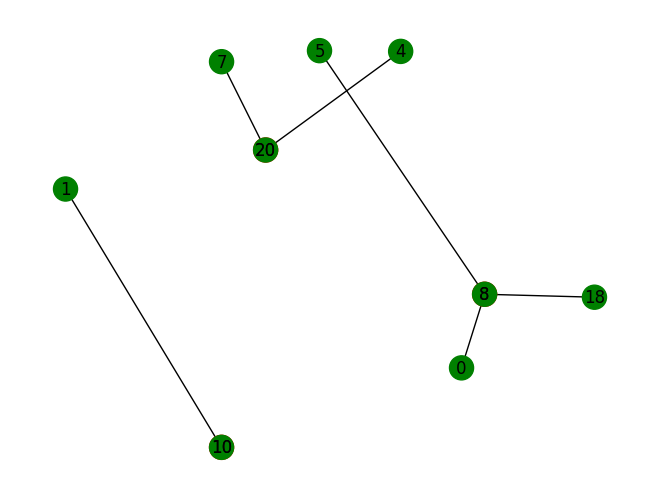

In [130]:
my_colors = ['red', 'green', 'blue', 'black']
color_graph = nx.Graph()

for n in topo.nodes():
    if n in donors:
        neighs = list(nx.neighbors(topo, n))
        color_graph.add_node(n, ues=neighs, x=topo.nodes[n]['x'], y=topo.nodes[n]['y'])
        for n1 in neighs:
            neighs1 = list(nx.neighbors(topo, n))
            color_graph.add_node(n1, ues=neighs, x=topo.nodes[n1]['x'], y=topo.nodes[n1]['y'])
            color_graph.add_edge(n, n1)
        
#nx.equitable_color()

pos = {n: (d['y'], d['x']) for n, d in color_graph.nodes(data=True)}
col = nx.coloring.greedy_color(color_graph)
print(col)
print([my_colors[col[i]] for i in color_graph.nodes()])
nx.draw(color_graph, 
        pos=pos,
        node_color=[my_colors[col[i]] for i in color_graph.nodes()])
a = nx.draw_networkx_labels(color_graph, 
                            pos=pos, 
                            labels={n:n.split('_')[0] for n in color_graph.nodes()})

